# Optimal Curriculum Learning Schedule
This notebook implements the optimal control framework for curriculum learning, corresponding to Section 3.1 of the paper *A statistical physics framework for optimal learning*.

We determine optimal difficulty schedules by minimizing the generalization error using Pontrygin's Maximum Principle.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import math
from math import sqrt, pi, atan
import time
import sys

In [17]:
def Power(x,i):
    return x**i
def Sqrt(x):
    return np.sqrt(x)
def ArcSin(x):
    return np.arcsin(x)
def ArcCos(x):
    return np.arccos(x)
def Abs(x):
    return np.abs(x)
Pi=np.pi

In [18]:
#forward dynamics
def compute_update(x, eta,lamb, T, Delta):
    Q11,Q22,  M = x
    
    fQ11=-(eta*lamb*Q11)+(4*eta*(-(Q11/Sqrt(1+Q11+Delta*Q22))+(M*(2+Delta*Q22))/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/(Pi*(2+Q11+Delta*Q22))+(2*Power(eta,2)*(Pi/2.+ArcSin((Q11+Delta*Q22)/(2+3*(Q11+Delta*Q22)))-2*ArcSin(M/(Sqrt(2+3*(Q11+Delta*Q22))*Sqrt(-Power(M,2)+(1+Q11+Delta*Q22)*T)))))/(Power(Pi,2)*Sqrt(1+Q11+Delta*Q22))
    fQ22=-(eta*lamb*Q22)-(4*Delta*eta*Q22*(1/Sqrt(1+Q11+Delta*Q22)+M/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/(Pi*(2+Q11+Delta*Q22))+(Delta*Power(eta,2)*(Pi+2*ArcSin((Q11+Delta*Q22)/(2+3*Q11+3*Delta*Q22))-4*ArcSin(M/(Sqrt(2+3*Q11+3*Delta*Q22)*Sqrt(-Power(M,2)+T+Q11*T+Delta*Q22*T)))))/(Power(Pi,2)*Sqrt(1+Q11+Delta*Q22))
    fM=-0.5*(eta*lamb*M)+(2*eta*(-(M/Sqrt(1+Q11+Delta*Q22))+Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/(Pi*(2+Q11+Delta*Q22))
    
    return np.array([fQ11, fQ22, fM])


In [19]:
#backward dynamics

def compute_update_back(x,nu,eta,lamb, T, Delta):
    Q11,Q22,  M = x
    nuQ11, nuQ22,  nuM = nu
    
    Q11fQ11=-(eta*lamb)+(4*eta*(Q11/(2.*Power(1+Q11+Delta*Q22,1.5))-1/Sqrt(1+Q11+Delta*Q22)-(M*(2+Delta*Q22)*T)/(2.*Power(-Power(M,2)+(2+Q11+Delta*Q22)*T,1.5))))/(Pi*(2+Q11+Delta*Q22))-(4*eta*(-(Q11/Sqrt(1+Q11+Delta*Q22))+(M*(2+Delta*Q22))/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/(Pi*Power(2+Q11+Delta*Q22,2))+(2*Power(eta,2)*(1/(Power(2+3*Q11+3*Delta*Q22,2)*Sqrt((1+2*Power(Q11,2)+3*Delta*Q22+2*Power(Delta,2)*Power(Q22,2)+Q11*(3+4*Delta*Q22))/Power(2+3*Q11+3*Delta*Q22,2)))+(-3*Power(M,3)+M*(5+6*Q11+6*Delta*Q22)*T)/(Power(2+3*Q11+3*Delta*Q22,1.5)*Power(-Power(M,2)+(1+Q11+Delta*Q22)*T,1.5)*Sqrt(1-Power(M,2)/((2+3*Q11+3*Delta*Q22)*(-Power(M,2)+(1+Q11+Delta*Q22)*T))))))/(Power(Pi,2)*Sqrt(1+Q11+Delta*Q22))-(Power(eta,2)*(Pi+2*ArcSin((Q11+Delta*Q22)/(2+3*Q11+3*Delta*Q22))-4*ArcSin(M/(Sqrt(2+3*Q11+3*Delta*Q22)*Sqrt(-Power(M,2)+T+Q11*T+Delta*Q22*T)))))/(2.*Power(Pi,2)*Power(1+Q11+Delta*Q22,1.5))
    Q22fQ11=(eta*((-8*Delta*Pi*(-(Q11/Sqrt(1+Q11+Delta*Q22))+(M*(2+Delta*Q22))/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/Power(2+Q11+Delta*Q22,2)+(4*Delta*Pi*(Q11/Power(1+Q11+Delta*Q22,1.5)+(-2*Power(M,3)+M*(2+2*Q11+Delta*Q22)*T)/Power(-Power(M,2)+(2+Q11+Delta*Q22)*T,1.5)))/(2+Q11+Delta*Q22)+(4*eta*(Delta/(Power(2+3*Q11+3*Delta*Q22,2)*Sqrt((1+2*Power(Q11,2)+3*Delta*Q22+2*Power(Delta,2)*Power(Q22,2)+Q11*(3+4*Delta*Q22))/Power(2+3*Q11+3*Delta*Q22,2)))+(Delta*M*(-3*Power(M,2)+(5+6*Q11+6*Delta*Q22)*T))/(Power(2+3*Q11+3*Delta*Q22,1.5)*Power(-Power(M,2)+(1+Q11+Delta*Q22)*T,1.5)*Sqrt(1-Power(M,2)/((2+3*Q11+3*Delta*Q22)*(-Power(M,2)+(1+Q11+Delta*Q22)*T))))))/Sqrt(1+Q11+Delta*Q22)-(Delta*eta*(Pi+2*ArcSin((Q11+Delta*Q22)/(2+3*Q11+3*Delta*Q22))-4*ArcSin(M/(Sqrt(2+3*Q11+3*Delta*Q22)*Sqrt(-Power(M,2)+T+Q11*T+Delta*Q22*T)))))/Power(1+Q11+Delta*Q22,1.5)))/(2.*Power(Pi,2))
    MfQ11=(4*eta*T*((Pi*(2+Delta*Q22))/Power(-Power(M,2)+(2+Q11+Delta*Q22)*T,1.5)-(eta*Sqrt(1+Q11+Delta*Q22))/(Sqrt(2+3*Q11+3*Delta*Q22)*Power(-Power(M,2)+(1+Q11+Delta*Q22)*T,1.5)*Sqrt(1-Power(M,2)/((2+3*Q11+3*Delta*Q22)*(-Power(M,2)+(1+Q11+Delta*Q22)*T))))))/Power(Pi,2)
    Q11fQ22=(Delta*eta*((4*Pi*Q22*(Power(1+Q11+Delta*Q22,-1.5)+(M*T)/Power(-Power(M,2)+(2+Q11+Delta*Q22)*T,1.5)))/(2+Q11+Delta*Q22)+(8*Pi*Q22*(1/Sqrt(1+Q11+Delta*Q22)+M/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/Power(2+Q11+Delta*Q22,2)+(4*eta*(1/(Power(2+3*Q11+3*Delta*Q22,2)*Sqrt((1+2*Power(Q11,2)+3*Delta*Q22+2*Power(Delta,2)*Power(Q22,2)+Q11*(3+4*Delta*Q22))/Power(2+3*Q11+3*Delta*Q22,2)))+(-3*Power(M,3)+M*(5+6*Q11+6*Delta*Q22)*T)/(Power(2+3*Q11+3*Delta*Q22,1.5)*Power(-Power(M,2)+(1+Q11+Delta*Q22)*T,1.5)*Sqrt(1-Power(M,2)/((2+3*Q11+3*Delta*Q22)*(-Power(M,2)+(1+Q11+Delta*Q22)*T))))))/Sqrt(1+Q11+Delta*Q22)-(eta*(Pi+2*ArcSin((Q11+Delta*Q22)/(2+3*Q11+3*Delta*Q22))-4*ArcSin(M/(Sqrt(2+3*Q11+3*Delta*Q22)*Sqrt(-Power(M,2)+T+Q11*T+Delta*Q22*T)))))/Power(1+Q11+Delta*Q22,1.5)))/(2.*Power(Pi,2))
    Q22fQ22=-(eta*lamb)+(2*Power(Delta,2)*eta*Q22*(Power(1+Q11+Delta*Q22,-1.5)+(M*T)/Power(-Power(M,2)+(2+Q11+Delta*Q22)*T,1.5)))/(Pi*(2+Q11+Delta*Q22))+(4*Power(Delta,2)*eta*Q22*(1/Sqrt(1+Q11+Delta*Q22)+M/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/(Pi*Power(2+Q11+Delta*Q22,2))-(4*Delta*eta*(1/Sqrt(1+Q11+Delta*Q22)+M/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/(Pi*(2+Q11+Delta*Q22))+(2*Delta*Power(eta,2)*(Delta/(Power(2+3*Q11+3*Delta*Q22,2)*Sqrt((1+2*Power(Q11,2)+3*Delta*Q22+2*Power(Delta,2)*Power(Q22,2)+Q11*(3+4*Delta*Q22))/Power(2+3*Q11+3*Delta*Q22,2)))+(Delta*M*(-3*Power(M,2)+(5+6*Q11+6*Delta*Q22)*T))/(Power(2+3*Q11+3*Delta*Q22,1.5)*Power(-Power(M,2)+(1+Q11+Delta*Q22)*T,1.5)*Sqrt(1-Power(M,2)/((2+3*Q11+3*Delta*Q22)*(-Power(M,2)+(1+Q11+Delta*Q22)*T))))))/(Power(Pi,2)*Sqrt(1+Q11+Delta*Q22))-(Power(Delta,2)*Power(eta,2)*(Pi+2*ArcSin((Q11+Delta*Q22)/(2+3*Q11+3*Delta*Q22))-4*ArcSin(M/(Sqrt(2+3*Q11+3*Delta*Q22)*Sqrt(-Power(M,2)+T+Q11*T+Delta*Q22*T)))))/(2.*Power(Pi,2)*Power(1+Q11+Delta*Q22,1.5))
    MfQ22=(4*Delta*eta*T*(-((Pi*Q22)/Power(-Power(M,2)+(2+Q11+Delta*Q22)*T,1.5))-(eta*Sqrt(1+Q11+Delta*Q22))/(Sqrt(2+3*Q11+3*Delta*Q22)*Power(-Power(M,2)+(1+Q11+Delta*Q22)*T,1.5)*Sqrt(1-Power(M,2)/((2+3*Q11+3*Delta*Q22)*(-Power(M,2)+(1+Q11+Delta*Q22)*T))))))/Power(Pi,2)
    Q11fM=(2*eta*(M/Sqrt(1+Q11+Delta*Q22)-Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)+((2+Q11+Delta*Q22)*(M/Power(1+Q11+Delta*Q22,1.5)+T/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/2.))/(Pi*Power(2+Q11+Delta*Q22,2))
    Q22fM=(2*eta*((Delta*M)/Sqrt(1+Q11+Delta*Q22)-Delta*Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)+(Delta*(2+Q11+Delta*Q22)*(M/Power(1+Q11+Delta*Q22,1.5)+T/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/2.))/(Pi*Power(2+Q11+Delta*Q22,2))
    MfM=-0.5*(eta*lamb)+(2*eta*(-(1/Sqrt(1+Q11+Delta*Q22))-M/Sqrt(-Power(M,2)+(2+Q11+Delta*Q22)*T)))/(Pi*(2+Q11+Delta*Q22))
 
    return np.array([nuQ11*Q11fQ11+nuQ22*Q11fQ22+nuM*Q11fM,nuQ11*Q22fQ11+nuQ22*Q22fQ22+nuM*Q22fM,nuQ11*MfQ11+nuQ22*MfQ22+nuM*MfM])

In [20]:
def damping(new,old,coef=0.4):
    return coef*old+(1-coef)*new

In [21]:
#Hamiltonian of PMP
def H(x,nu,eta,lamb,T,Delta):
    nuQr, nuQi,  nuR = nu
    fQr, fQi, fR=compute_update(x, eta,lamb, T, Delta)
    return nuQr*fQr+nuQi*fQi+nuR*fR

In [22]:
#Optimality condition
def compute_Delta_discrete(xs,nus,etas,lambs,T,N1=0,Delta1=0,Delta2=1):
    
 
    ret_delta=np.ones(len(xs))
    
    DeltaH=[H(xs[i],nus[i],etas[i],lambs[i],T,Delta2)-H(xs[i],nus[i],etas[i],lambs[i],T,Delta1) for i in range(len(xs))]

    indeces=np.argsort(DeltaH)[-N1:]

    ret_delta=np.ones(len(xs))*Delta2
    ret_delta[indeces]=Delta1
    
    return ret_delta

In [23]:
#final condition of the backward dynamics
def compute_nu_final(xf,T,Delta1,Delta2,p1):
    
    
    Q11,Q22,M = xf
    
    Delta=Delta1
    Q11gen1=(M*T)/(2.*Pi*Power((Q11 + Delta*Q22)*T,1.5)*Sqrt(1 - Power(M,2)/(Q11*T + Delta*Q22*T)))
    Q22gen1=(Delta*M*T)/(2.*Pi*Power((Q11 + Delta*Q22)*T,1.5)*Sqrt(1 - Power(M,2)/(Q11*T + Delta*Q22*T)))
    Mgen1=-(1/(Pi*Sqrt((Q11 + Delta*Q22)*T)*Sqrt(1 - Power(M,2)/(Q11*T + Delta*Q22*T))))
    
    Delta=Delta2
    Q11gen2=(M*T)/(2.*Pi*Power((Q11 + Delta*Q22)*T,1.5)*Sqrt(1 - Power(M,2)/(Q11*T + Delta*Q22*T)))
    Q22gen2=(Delta*M*T)/(2.*Pi*Power((Q11 + Delta*Q22)*T,1.5)*Sqrt(1 - Power(M,2)/(Q11*T + Delta*Q22*T)))
    Mgen2=-(1/(Pi*Sqrt((Q11 + Delta*Q22)*T)*Sqrt(1 - Power(M,2)/(Q11*T + Delta*Q22*T))))
    
    
    return [Q11gen1*p1+Q11gen2*(1-p1),Q22gen1*p1+Q22gen2*(1-p1),Mgen1*p1+Mgen2*(1-p1)]

In [24]:
#generalization error
def compute_generalization(x,T,Delta1,Delta2,p1):
    Qr,Qi,R = x

    return p1*ArcCos(R/Sqrt((Delta1*Qi + Qr)*T))/Pi+(1-p1)*ArcCos(R/Sqrt((Delta2*Qi + Qr)*T))/Pi

In [25]:

def integrate_forward(xs,errors,etas,lambs,Deltas,epochs,dt,Delta1,Delta2,p1,T):
    # Euler method
    errors[0]=compute_generalization(xs[0],T,Delta1,Delta2,p1)
    for a in range(epochs):
        xs[a+1]=xs[a]+dt*compute_update(xs[a], etas[a],lambs[a], T, Deltas[a])
        errors[a+1]=compute_generalization(xs[a+1],T,Delta1,Delta2,p1)
    return xs, errors

In [26]:
def integrate_backward(xs,nus,etas,lambs,Deltas,epochs,dt,Delta1,Delta2,p1,T):
    nus[0]=compute_nu_final(xs[-1],T,Delta1,Delta2,p1)
    for a in range(epochs):
        nus[a+1]=nus[a]+dt*compute_update_back(xs[-a-1],nus[a],etas[-a-1],lambs[-a-1], T, Deltas[-a-1])
    return np.flip(nus,axis=0)

In [27]:
#forward-backward sweep method

def iterate_equations(x0,T,epochs,dt,Deltas,etas,lambs,N1=0,Delta1=0,Delta2=1,max_iter=1000,coef=0.5,tol=10**(-6),printing=True):
    

    
    nus=np.zeros((epochs+1,3))
    xs=np.zeros((epochs+1,3))
    errors=np.zeros(epochs+1)
    

    nus_tmp=np.zeros((epochs+1,3))
    xs_tmp=np.zeros((epochs+1,3))


    final_error=[]
    
    xs[0]=x0
    xs_tmp[0]=x0
    p1=N1/len(xs)

    #Forward iteration 
    xs, errors=integrate_forward(xs,errors,etas,lambs,Deltas,epochs,dt,Delta1,Delta2,p1,T)
    #Backward iteration 
    nus=integrate_backward(xs,nus,etas,lambs,Deltas,epochs,dt,Delta1,Delta2,p1,T)

    for it in range(max_iter):
    
        Delta_tmp=compute_Delta_discrete(xs,nus,etas,lambs,T,N1,Delta1,Delta2)

        #Forward iteration 
        xs_tmp, errors=integrate_forward(xs_tmp,errors,etas,lambs,Delta_tmp,epochs,dt,Delta1,Delta2,p1,T)
        #Backward iteration 
        nus_tmp=integrate_backward(xs_tmp,nus_tmp,etas,lambs,Delta_tmp,epochs,dt,Delta1,Delta2,p1,T)
        
        #Update sigma
        convergence_error=np.mean((xs_tmp-xs)**2)+np.mean((nus_tmp-nus)**2)
        
        Deltas=Delta_tmp.copy()

        xs=damping(xs_tmp,xs,coef)
        nus=damping(nus_tmp,nus,coef)

     
        final_error.append(errors[-1])
    
        if printing:
            sys.stdout.write("\r Step {}/{} done! Convergence error={:.10f} Generalization error={:.10f} ".format(it,max_iter,convergence_error,errors[-1]))
            sys.stdout.flush()
            
        if tol>=convergence_error:
            break
            
        if it>max_iter/10:
            coef=0.999
    if tol<convergence_error:
        print("Error: not converged")
    return xs,nus,Deltas,etas,final_error,convergence_error

In [28]:
alphaF=12 #total time
dt=0.05 #integration step
epochs=int(alphaF/dt)
lamb=0 #regularization
eta=3 #learning rate
Delta1=0 #easy noise level
Delta2=2 #hard noise level
p1=0.5 #fraction of easy examples

In [29]:
#PMP hyperparameters
coef=0.99 #damping coefficient
max_iter=10000 #maximum number of iterations
tol=10**(-4) #tolerance
printing=True

In [30]:
np.random.seed(2)
N1=int(epochs*p1)
T=2 #norm of teacher weights
x0=[1,1,0] #initial condition 
etas=np.ones(epochs+1)*eta
lambs=np.ones(epochs+1)*lamb
Deltas=np.ones(epochs+1)*Delta2
Deltas[:N1]=Delta1
np.random.shuffle(Deltas)
t_init=time.time()
[xs,nus,Deltas,etas,final_error,convergence_error]=iterate_equations(x0,T,epochs,dt,Deltas,etas,lambs,N1=N1,Delta1=Delta1,Delta2=Delta2,max_iter=max_iter,coef=coef,tol=tol,printing=printing)

 Step 399/10000 done! Convergence error=0.0000967432 Generalization error=0.1466824690 

In [31]:
#Evaluate optimal strategy
xs=np.zeros((epochs+1,3))
xs[0]=x0
errors=np.zeros(epochs+1)
Deltas_opt=[round(d) for d in Deltas]
xs, errors=integrate_forward(xs,errors,etas,lambs,Deltas_opt,epochs,dt,Delta1,Delta2,p1,T)

#Evaluate easy-to-hard curriculum
xs=np.zeros((epochs+1,3))
errors_curr=np.zeros(epochs+1)
xs[0]=x0

Deltas_curr = [
    Delta1 if i < epochs/2 else Delta2
    for i in range(epochs)]
xs, errors_curr=integrate_forward(xs,errors_curr,etas,lambs,Deltas_curr,epochs,dt,Delta1,Delta2,p1,T)

#Evaluate hard-to-easy curriculum
xs=np.zeros((epochs+1,3))
errors_anticurr=np.zeros(epochs+1)
xs[0]=x0
Deltas_anticurr = [
    Delta2 if i < epochs/2 else Delta1
    for i in range(epochs)]
xs, errors_anticurr=integrate_forward(xs,errors_anticurr,etas,lambs,Deltas_anticurr,epochs,dt,Delta1,Delta2,p1,T)

## Results and Visualization

In [33]:
alphas=np.linspace(0,alphaF,epochs+1)

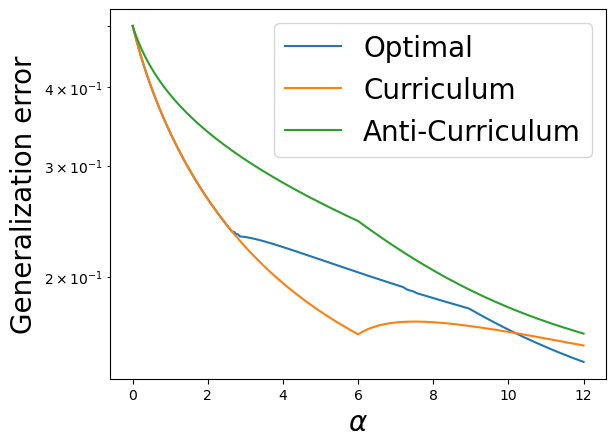

In [34]:
plt.plot(alphas,errors,label="Optimal")
plt.plot(alphas,errors_curr,label="Curriculum")
plt.plot(alphas,errors_anticurr,label="Anti-Curriculum")
plt.yscale("log")
plt.xlabel(r"$\alpha$",fontsize=20)
plt.ylabel(r"Generalization error",fontsize=20)
plt.legend(fontsize=20)